In [57]:
# ========================
# 📦 Import Cell
# ========================

# 基本套件
import os
import gc
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
 
# 圖像處理與視覺化
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn 工具（交叉驗證、評估指標等）
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# PyTorch 基本套件
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 資料增強
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 設定亂數種子與顯示參數
import warnings
warnings.filterwarnings("ignore")
!pip install imagecodecs
# 加速圖片讀取（可選）
from PIL import Image
print("import finish")

import finish


In [58]:
# ========================
# ⚙️ Config Cell
# ========================
class CFG:
    # 基本設定
    competition_name = "PANDA"
    seed = 42
    debug = False  # 若為 True，會使用更小的資料量快速測試

    # 資料路徑（原始資料）
    data_dir = "/home/gpl_homee/CVDL_Final/data"
    
    # 圖像處理參數
    tile_size = 256
    tile_count = 8
    n_tiles = tile_count ** 2 
    image_size = tile_size * tile_count  

    # 分類任務參數
    num_classes = 6  # ISUP grade 0~5

    # 訓練參數
    n_fold = 4
    fold_seed = 42
    target_col = "isup_grade"
    fold = 0 
    num_workers = 0
    batch_size = 4
    # 圖片讀取格式
    image_format = "tiff"  
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

In [59]:
# ========================
# 📦 Dataset Cell
# ========================
import skimage.io
from torch.utils.data import Dataset
import openslide
from PIL import Image

def get_tiles(img, tile_size = 256, n_tiles = 64):
    """
    從輸入影像中擷取前景 tile，並回傳 tile 的 list
    """
    h, w, c = img.shape
    pad_h = (tile_size - h % tile_size) % tile_size
    pad_w = (tile_size - w % tile_size) % tile_size
    img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), constant_values=255)
    
    img = img.reshape(img.shape[0] // tile_size, tile_size,
                      img.shape[1] // tile_size, tile_size, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, 3)

    # 根據 tile 的平均亮度進行排序（去除背景）
    idxs = np.argsort(img.reshape(img.shape[0], -1).mean(-1))[:n_tiles]
    tiles = img[idxs]
    
    # 若不夠 tile，補白
    if len(tiles) < n_tiles:
        white_tile = np.full((tile_size, tile_size, 3), 255, dtype=np.uint8)
        tiles += [white_tile] * (n_tiles - len(tiles))
    
    return tiles

def tile_concat(tiles, tile_size = 256, n_tiles = 64):
    """
    將 tiles 排列為 (sqrt(n) x sqrt(n)) 的大圖
    """
    grid_size = int(n_tiles ** 0.5)
    result = np.zeros((tile_size * grid_size, tile_size * grid_size, 3), dtype=np.uint8)
    
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            if idx < len(tiles):
                result[i * tile_size:(i + 1) * tile_size,
                       j * tile_size:(j + 1) * tile_size] = tiles[idx]
    return result

class PandaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image_id = row.image_id
        label = row[CFG.target_col]

        slide_path = os.path.join(CFG.data_dir, "train_images", f"{image_id}.tiff")
        print(f"Attempting to load: {slide_path}")
        """
        print(slide_path)
        slide = openslide.OpenSlide(slide_path)
        img = slide.read_region((0, 0), 0, slide.level_dimensions[0])
        img = np.array(img)[:, :, :3]
        """
        multi_img = skimage.io.MultiImage(slide_path)
        print(f"Number of layers found in {image_id}.tiff: {len(multi_img)}")
        if len(multi_img) > 1:
            img = multi_img[1]
        else:
            img = multi_img[0]
        tiles = get_tiles(img, CFG.tile_size, CFG.n_tiles)
        image = tile_concat(tiles, CFG.tile_size, CFG.n_tiles)

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [60]:
# ========================
# 🧩 Create Folds Cell
# ========================

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

# 讀取原始訓練資料
df = pd.read_csv(os.path.join(CFG.data_dir, "train.csv"))

# 移除重複影像（視需要）
df = df.drop_duplicates(subset="image_id").reset_index(drop=True)

# 建立 Stratified K-Fold 切分
df["fold"] = -1
skf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.fold_seed)
for fold, (_, val_idx) in enumerate(skf.split(df, df[CFG.target_col])):
    df.loc[val_idx, "fold"] = fold

# 顯示每一 fold 的分佈
print(df["fold"].value_counts())
print(df.groupby("fold")[CFG.target_col].value_counts())

# 儲存或保留在記憶體中
# df.to_csv("train_folds.csv", index=False)

fold
3    2654
0    2654
2    2654
1    2654
Name: count, dtype: int64
fold  isup_grade
0     0             723
      1             666
      2             335
      4             313
      3             311
      5             306
1     0             723
      1             667
      2             336
      4             312
      3             310
      5             306
2     0             723
      1             667
      2             336
      4             312
      3             310
      5             306
3     0             723
      1             666
      2             336
      4             312
      3             311
      5             306
Name: count, dtype: int64


In [61]:
# ========================
# 🧪 Augmentations Cell
# ========================

from torchvision import transforms

def get_transforms(mode="train"):
    if mode == "train":
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
        ])

In [62]:
# ========================
# 🚚 Create Dataloader Cell
# ========================

from torch.utils.data import DataLoader

# 按照 fold split 資訊切分訓練與驗證資料
train_df = df[df['fold'] != CFG.fold].reset_index(drop=True)
valid_df = df[df['fold'] == CFG.fold].reset_index(drop=True)

# 建立 Dataset 物件
train_dataset = PandaDataset(train_df, transform=get_transforms(mode="train"))
valid_dataset = PandaDataset(valid_df, transform=get_transforms(mode="valid"))

# 建立 Dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.num_workers,
    pin_memory=True,
    drop_last=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.num_workers,
    pin_memory=True
)

Attempting to load: /home/gpl_homee/CVDL_Final/data/train_images/725fc40fce67c6980c56cc17eafd0eb0.tiff
Number of layers found in 725fc40fce67c6980c56cc17eafd0eb0.tiff: 1
Attempting to load: /home/gpl_homee/CVDL_Final/data/train_images/6129f36d2604ad122625914947cfce61.tiff
Number of layers found in 6129f36d2604ad122625914947cfce61.tiff: 1
Attempting to load: /home/gpl_homee/CVDL_Final/data/train_images/f8b3ec914967ad95c62ef0296964394b.tiff
Number of layers found in f8b3ec914967ad95c62ef0296964394b.tiff: 1
Attempting to load: /home/gpl_homee/CVDL_Final/data/train_images/bd8574cd5bcbedb9213ca45e8beb7561.tiff
Number of layers found in bd8574cd5bcbedb9213ca45e8beb7561.tiff: 1


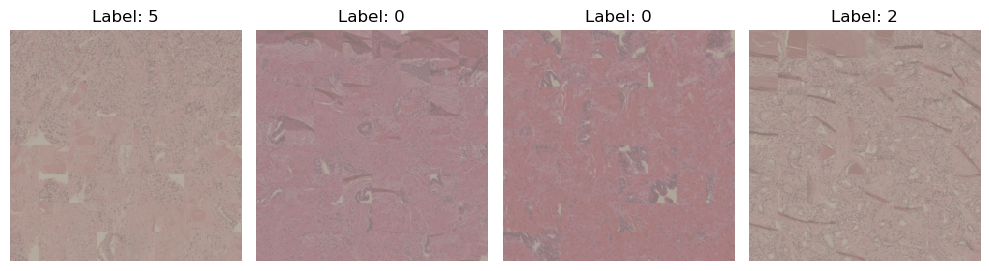

In [63]:
# ========================
# 🖼️ Visualize Dataloader Cell
# ========================

import matplotlib.pyplot as plt
import torchvision

# 從 train_loader 中取出一個 batch
batch = next(iter(train_loader))
images, labels = batch

# 還原標準化：從 tensor 還原到原始圖像（約 0~1）
def denormalize(img_tensor):
    mean = torch.tensor(CFG.mean).view(3, 1, 1)
    std = torch.tensor(CFG.std).view(3, 1, 1)
    return img_tensor * std + mean

# 顯示前兩張圖片與其標籤
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    axs[i].imshow(img.clip(0, 1))
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()